In [1]:
import os

import numpy as np
import tensorflow as tf

In [2]:
def load_data(path):
    x = None
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'rb') as f:
            tmp = tf.cast([np.load(f)], dtype=tf.float64)
            if x is None:
                x = tf.linalg.matmul(tmp, tmp, transpose_b=True)
            else:
                x = tf.concat([x, tf.linalg.matmul(tmp, tmp, transpose_b=True)], axis=0)
    return x

In [3]:
steps, runs_per_k = 200, 3
# alphas, betas, gammas = [0.1, 1.0], [1000.0, 2000.0, 100.0], [0.01, 0.1]
alphas, betas, gammas = [0.1], [1000.0, 2000.0], [0.01, 0.1]
# alphas, betas, gammas = [0.1], [1000.0], [0.01]

In [4]:
def fusion(x, k, alpha, beta, gamma):
    f = None
    n = x.shape[1]
    t = x.shape[0]
    reg = gamma / (4.0 * beta)
    wv, wv_u = tf.cast([1.0 / t for _ in range(t)], dtype=tf.float64), None
    i_alpha = tf.math.multiply(tf.eye(n, dtype=tf.float64), alpha)
    i_beta = tf.math.multiply(tf.eye(n, dtype=tf.float64), beta)
    s = tf.eye(n, dtype=tf.float64)
    for step in range(steps):
        s = tf.where(s > 0, s, tf.zeros(s.shape, dtype=tf.float64))
        s = tf.math.divide(tf.math.add(s, tf.transpose(s)), 2.0)
        z_sum = tf.zeros(s.shape, dtype=tf.float64)
        for i in range(t):
            z = tf.linalg.solve(
                tf.math.add(tf.math.add(x[i], i_alpha), tf.math.multiply(i_beta, wv[i])),
                tf.math.add(tf.math.multiply(s, tf.math.multiply(wv[i], beta)), x[i]))
            z = tf.where(z > 0, z, tf.zeros(z.shape, dtype=tf.float64))
            z = tf.math.divide(tf.math.add(z, tf.transpose(z)), 2.0)
            w = tf.math.divide(0.5, tf.norm(tf.math.subtract(z, s)))
            wv_u = tf.reshape(w, [1]) if i == 0 else tf.concat([wv_u, [w]], axis=0)
            z = tf.math.multiply(z, w)
            z_sum = tf.math.add(z_sum, z)

        l = tf.math.subtract(tf.linalg.diag(tf.math.reduce_sum(s, 0)), s)
        (_, f) = tf.linalg.eigh(l)
        f = tf.slice(f, [0, 0], [f.shape[0], k])
        p = tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)
        for i in range(1, n):
             p = tf.concat([p, tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)], 1)
        p = tf.math.multiply(tf.math.square(p), reg)
        wv = wv_u
        s_old = s
        s = tf.math.divide((tf.math.subtract(z_sum, p)), tf.math.reduce_sum(wv, 0))
        if step >= 4 and tf.math.less(tf.math.divide(tf.norm(tf.math.subtract(s, s_old)), tf.norm(s_old)), 1.e-3):
            # print('Criterion found after', step + 1, 'steps')
            return f
    return f

In [5]:
from sklearn.cluster import KMeans

histograms, min_k, clusters = {}, {}, {}
def run_k_means(k, f):
        k_means = KMeans(n_clusters=k, n_init=10).fit(f)
        cluster = k_means.labels_
        d = {}
        for i in cluster:
            if i in d:
                d[i] += 1
            else:
                d[i] = 1
        max_k, smallest = 0, float('inf')
        for i in d:
            max_k = max(max_k, d[i])
            smallest = min(smallest, d[i])
        if k in min_k:
            if max_k < min_k[k]:
                min_k[k] = max_k
                histograms[k] = d
                clusters[k] = cluster
                print('k:', k)
                print(d, '\nBiggest cluster:', max_k, 'Smallest cluster:', smallest, '\n')
        else:
            min_k[k] = max_k
            histograms[k] = d
            clusters[k] = cluster
            print('k:', k)
            print(d, '\nBiggest cluster:', max_k, 'Smallest cluster:', smallest, '\n')

In [6]:
def run_experiments(ks, views):    
    x = load_data(views)
    print(x.shape)
    for _ in range(runs_per_k):
        for k in ks:
            for alpha in alphas:
                for beta in betas:
                    for gamma in gammas:
                        print('Run with parameters', alpha, beta, gamma)
                        run_k_means(k, fusion(x, k, alpha, beta, gamma).numpy())

In [7]:
def save_np(name, matrix):
    with open(name + ".npy", 'wb') as f:
        np.save(f, matrix)

def save_results(folder):
    for k in clusters:        
        save_np(folder + str(k) + '_means', clusters[k])

In [8]:
run_experiments([40, 70, 100, 150], 'views/profiles/')
save_results('clusters/profiles/')

(2, 1236, 1236)
Run with parameters 0.1 1000.0 0.01
k: 40
{4: 119, 35: 12, 11: 17, 7: 26, 15: 5, 17: 26, 37: 115, 34: 25, 23: 7, 31: 14, 6: 16, 1: 23, 0: 139, 3: 105, 24: 11, 18: 24, 32: 11, 27: 38, 30: 10, 5: 63, 36: 13, 20: 14, 2: 15, 19: 17, 29: 25, 8: 44, 38: 13, 22: 33, 13: 18, 25: 14, 33: 16, 39: 17, 21: 22, 28: 40, 12: 23, 14: 30, 9: 18, 10: 36, 16: 12, 26: 10} 
Biggest cluster: 139 Smallest cluster: 5 

Run with parameters 0.1 1000.0 0.1
Run with parameters 0.1 2000.0 0.01
Run with parameters 0.1 2000.0 0.1
Run with parameters 0.1 1000.0 0.01
k: 70
{41: 81, 69: 5, 33: 13, 2: 23, 34: 5, 68: 3, 65: 7, 62: 17, 5: 7, 44: 17, 61: 69, 59: 8, 50: 20, 24: 12, 3: 106, 16: 9, 35: 20, 56: 10, 28: 16, 51: 10, 15: 22, 60: 12, 47: 8, 57: 57, 36: 11, 52: 7, 23: 10, 37: 19, 39: 16, 40: 32, 32: 11, 21: 12, 25: 11, 4: 15, 31: 13, 64: 12, 29: 14, 46: 85, 11: 26, 66: 17, 63: 13, 12: 13, 55: 100, 13: 8, 49: 13, 58: 11, 22: 15, 0: 15, 67: 8, 27: 10, 10: 20, 45: 8, 38: 13, 17: 13, 6: 24, 18: 9, 14: 1

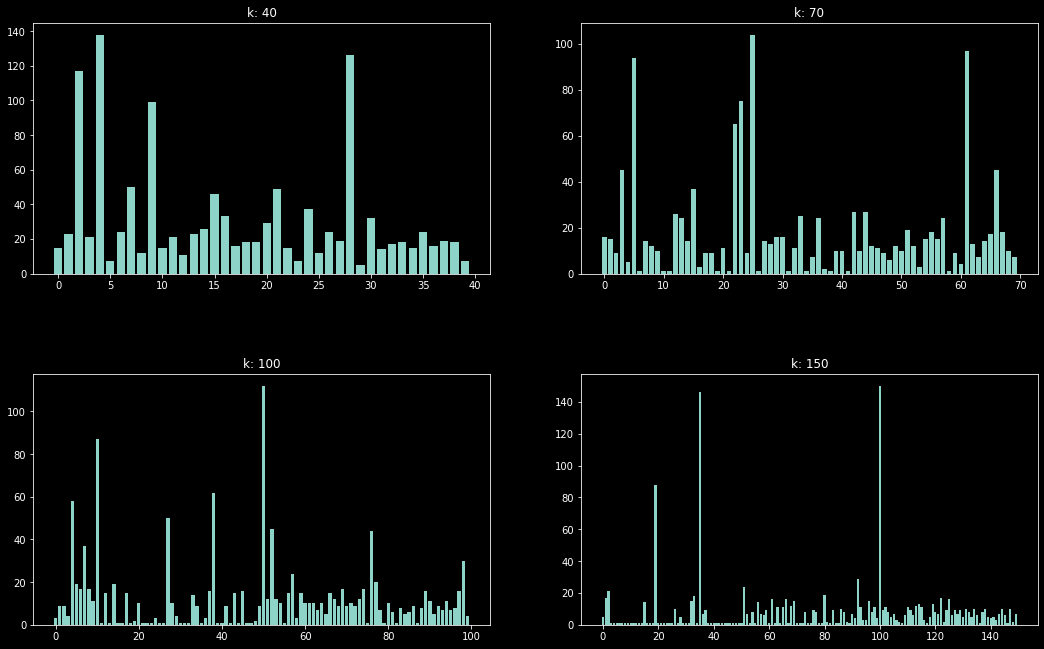

In [9]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_histograms():
    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(hspace=0.4)
    cnt = 1
    for i in histograms:
        plt.subplot(len(histograms), 2, cnt)
        cnt += 1
        d = histograms[i]
        plt.bar(d.keys(), d.values())
        plt.title('k: ' + str(i))

plot_histograms()